In [1]:
## Setup
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import csv

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


Loading vector data
Loading image data
Preprocessing data
Input shape:  (9400, 10)


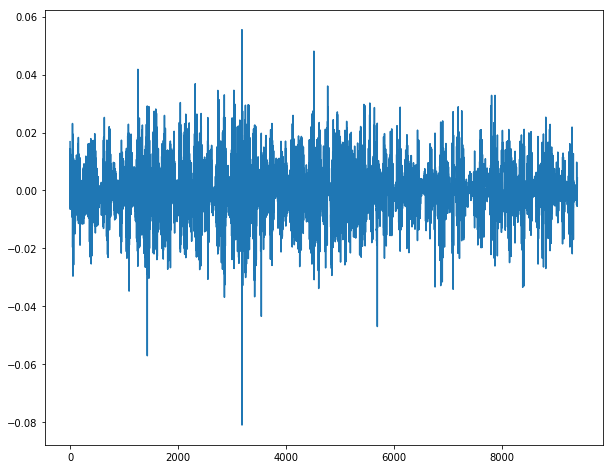

In [2]:
TRAIN_RATIO = 0.6

import utilities
# Datafile options:
x_data,img_data,y_data = utilities.load_data('flows_lowres_16k.npy')
#imu_data,flows_data,y_norm = utilities.load_data('../gbucket/center_cropped_300x300.npy')
#imu_data,x_data,y_norm = utilities.load_data('../gbucket/center_cropped_192x192.npy')

# Split into training/val data:
N_training = int(TRAIN_RATIO*x_data.shape[0])
N_validation = x_data.shape[0]- N_training

x_train = x_data[0:N_training,...]
img_train = img_data[0:N_training,...]
y_train = y_data[0:N_training]


img_val = img_data[N_training:,...]
x_val = x_data[N_training:,...]
y_val = y_data[N_training:]

print('Input shape: ', x_data.shape)

# Plot the discretization with perfect classification:
plt.plot(y_data)



In [11]:
R_HISTORY = 8
BATCH_SIZE = 128
IMG_BATCH_SIZE = 64
N_HIDDEN = 1024

tf.reset_default_graph() # remove all existing variables in the graph 
sess = get_session() # start a new Session

# Load the convolutional side of the network:
from classifiers.squeezenet import SqueezeNet
conv_model = SqueezeNet(128, 2, img_data.shape[1])
convsaver = tf.train.Saver()
convsaver.restore(sess, './checkpoints/good_run')

# Load the recursive side of the network:
from classifiers.recursivenet import RecursiveNet
with tf.variable_scope('recursive_model'):
    model = RecursiveNet(BATCH_SIZE, R_HISTORY, N_HIDDEN)

# Activations from the conv side:
with tf.variable_scope('inputs'):
    feats = tf.reshape(conv_model.extract_features(conv_model.image, reuse=False),[1024,-1])
    input_imu = tf.placeholder('float', shape=[R_HISTORY*BATCH_SIZE, x_data.shape[1]])
    model.data = tf.concat([input_imu, feats], axis=1)

# Slow way to initialize variables that is robust to partially loaded models:
uninitialized_vars = []
for var in tf.global_variables():
    try:
        sess.run(var)
    except tf.errors.FailedPreconditionError:
        uninitialized_vars.append(var)
        
init = tf.variables_initializer(uninitialized_vars)
sess.run(init)

# Try a single iteration:
x_batch,y_batch = sample_seqbatch(BATCH_SIZE,R_HISTORY, [x_data,img_data],y_data)
imu_batch = x_batch[0]
img_batch = x_batch[1]
tmp = tf.run(model.optimizer, feed_dict={conv_model.image:img_batch, conv_model.labels:y_batch,input_imu:imu_batch,model.lr:0.01})


INFO:tensorflow:Restoring parameters from ./checkpoints/good_run


INFO:tensorflow:Restoring parameters from ./checkpoints/good_run


ValueError: Tried to convert 'tensor' to a tensor and failed. Error: Dimension 3 in both shapes must be equal, but are 384 and 512
	From merging shape 10 with other shapes. for 'inputs/Reshape/packed' (op: 'Pack') with input shapes: [?,?,?,64], [?,?,?,64], [?,?,?,64], [?,?,?,128], [?,?,?,128], [?,?,?,128], [?,?,?,256], [?,?,?,256], [?,?,?,256], [?,?,?,384], [?,?,?,384], [?,?,?,512], [?,?,?,512].

0
Step:  0  Train:  0.0199589  Val:  0.156918 LR:  0.00495


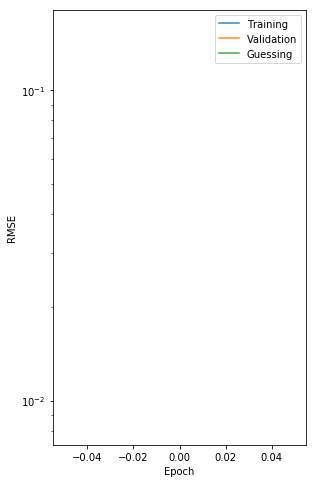

In [ ]:
# simple parameters:
disp_period = 1000
training_iters = 40000
lr = 0.005 
lr_decay= 0.99

# Launch the graph
step = 1 
history = {'train_loss': [], 's_tloss': [], 'val_inds': [], 'val_loss':[], 'corr':[]}
smooth_val = 0.999

for step in range(training_iters):
    if step % 300 is 0:
        print(step)
        lr *= lr_decay
    batch_x, batch_y = utilities.sample_seqbatch(R_HISTORY, BATCH_SIZE, x_train, y_train)
    o,loss = sess.run([model.optimizer,model.loss], feed_dict={model.data: batch_x, model.labels: batch_y, model.lr:[lr]})

    history["train_loss"].append(loss)
    if(step is 0):
        history["s_tloss"].append(loss)
    else:
        history["s_tloss"].append(smooth_val*history["s_tloss"][-1] + (1-smooth_val)*loss)

    if step % disp_period is 0:
        # Calculate val accuracy:
        batch_x, batch_y = utilities.sample_seqbatch(R_HISTORY, BATCH_SIZE, x_train, y_train)
        loss_v = sess.run(model.loss, feed_dict={model.data: batch_x, model.labels: batch_y})
        history["val_loss"].append(loss_v)
        history["val_inds"].append(step)

        print('Step: ', step, ' Train: ', history["s_tloss"][-1], ' Val: ', history["val_loss"][-1], 'LR: ', lr)

        rmse_zero = utilities.calc_rmse(np.zeros_like(y_data),y_data)

        saver.save(sess, './recursive_ckpts/recursive_model', global_step = step)
        # Only run prediction if it seems reasonable:
        if(history["s_tloss"][-1] < 1.5*rmse_zero and step %10*disp_period==0):
            y_pred = np.zeros_like(y_data)
            state = np.zeros(N_HIDDEN)
            print('Loss is ',history["s_tloss"][-1] ,'. Running Prediction: ')
            m_state = np.zeros(y_data.shape[0])
            y_pred = np.zeros(y_data.shape[0])
            for k in range( y_data.shape[0]-BATCH_SIZE*R_HISTORY):
                if k % 1000 is 0:
                    print('k = ', k)
                batch_x, batch_y = utilities.sample_seqbatch(R_HISTORY, BATCH_SIZE,x_data,y_data, k)
                if batch_x.shape[0] != R_HISTORY*BATCH_SIZE or batch_y.shape[0] != R_HISTORY*BATCH_SIZE:
                    print('Error in batch_x shape at ', k, ' shapes: ',batch_x.shape, batch_y.shape)
                    continue
                pred,state = sess.run([model.prediction,model.state], feed_dict={model.state:state,model.data: batch_x, model.labels: batch_y})
                m_state[k] = np.max(state)
                if k < y_pred.shape[0]:
                    y_pred[k] = pred[-1]
                else:
                    print('Error assigning to element ', k)
            c = utilities.plot_data(0,y_data.shape[0], y_pred, y_data, x_train.shape[0])
            history["corr"].append(c)

            rmse_pred = utilities.calc_rmse(y_pred, y_data)
            print('RMSE: ', rmse_pred)
            print('Ratio to zeros: ', rmse_pred/rmse_zero)

        plt.subplot(1,2,1)
        plt.semilogy(history["train_loss"],alpha=0.9)
        plt.semilogy(history["val_inds"], history["val_loss"],alpha=0.9)
        plt.semilogy([0,step], [rmse_zero,rmse_zero],alpha=0.9)
        plt.legend(['Training','Validation','Guessing'])
        plt.semilogy(history["s_tloss"],linewidth=4)
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')
#        plt.subplot(1,2,2)

#        plt.plot(history["val_inds"], history["corr"])
#        plt.ylabel('Correlation')
#        plt.xlabel('epoch') 
        
        
        plt.show()

    # Compute sequence prediction:
print('Done.')
